In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel, RBF
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

In [2]:

# --- 1. Generate Synthetic Data with Multiple Covariates ---
np.random.seed(42)

# Time component (periodicity will be based on this)
period = 24
num_samples = 100
time_data = np.sort(10 * np.random.rand(num_samples, 1), axis=0)

# Additional covariates
feature_names = ['time', 'temperature', 'pressure']
temp_data = 25 + 5 * np.random.randn(num_samples, 1) # e.g., temperature
pressure_data = 1000 + 20 * np.random.randn(num_samples, 1) # e.g., pressure

# Original combined X array (all features)
X_full = np.hstack((time_data, temp_data, pressure_data))

# Create a more complex 'y' that depends on time (periodically) and other covariates

"""
y = (np.sin(time_data * (2 * np.pi / period)) * 2
     + 0.1 * temp_data
     + 0.05 * pressure_data
     + 0.5 * np.random.randn(num_samples, 1)
    )
"""

y = (np.sin(time_data * (2 * np.pi / period)) * 2
     + 0.1 * temp_data
     + 0.5 * np.random.randn(num_samples, 1)
    )

# --- IMPORTANT: Scale the covariates before applying ARD ---
# Scale X_full
scaler_X = StandardScaler()
X_full_scaled = scaler_X.fit_transform(X_full)


In [3]:

# --- 2. Define the Gaussian Process Kernel with ARD (without active_dims) ---

# The trick is that each base kernel (ExpSineSquared, RBF) inherently operates
# on ALL dimensions passed to the GP.
# To achieve the 'active_dims' effect, you combine different kernels in a sum or product.
# The `length_scale` parameter of RBF and Matern can be a scalar or an array-like.
# If it's an array-like, it means ARD, and the length of the array must match
# the number of *total input dimensions* that the kernel *would* operate on.

# For ARD across ALL relevant dimensions (time, temp, pressure):
# Here, we will make an ARD RBF kernel that acts on all 3 dimensions.
# Then, we'll try to enforce periodicity on the first dimension through the ExpSineSquared.
# This approach models the data as (periodic_component + non_periodic_component + noise)

# This is often the more "correct" way in recent scikit-learn versions
# when you want ARD, as it applies ARD across all input dimensions
# and the periodic kernel will implicitly operate on the periodicity of the first dimension.

# Let's try combining:
# 1. A periodic kernel (ExpSineSquared) that will implicitly find periodicity in the first dimension
# 2. An RBF kernel with ARD for all dimensions (or specific non-periodic ones)
# 3. White noise

# Option 1: Separate ARD RBF for non-periodic dimensions, periodic for time.
# This is usually the most interpretable setup when you have a known periodic dimension
# and other independent non-periodic effects.

# Create an ExpSineSquared kernel that *implicitly* operates on all dimensions,
# but its periodicity will primarily be picked up from the time dimension.
# If `length_scale` is a scalar, it's isotropic. If it's an array, it's ARD.
# For ExpSineSquared, periodicity is usually isotropic, so we keep length_scale as scalar.
periodic_kernel = (ConstantKernel(1.0, (1e-3, 1e3)) *
                   ExpSineSquared(length_scale=1.0, periodicity=period,
                                  length_scale_bounds=(0.1, 10.0),
                                  periodicity_bounds="fixed"))

# Create an RBF kernel with ARD for the *other* dimensions (temp and pressure).
# This is where the trick comes in: you're defining a kernel that, when combined,
# will "know" which dimensions it should be sensitive to.
# Since we have 3 dimensions in X_full_scaled: [time, temp, pressure]
# If we want ARD for temp and pressure, but treat time separately with a periodic kernel,
# we need to consider how the RBF will interact.

# A common way to handle this without `active_dims` is to define the ARD RBF
# over all dimensions, but expect that the periodic kernel will dominate for the
# time dimension, and the RBF's length scale for time will become very large (low relevance).

# Let's try defining an ARD RBF that covers all 3 dimensions of X_full_scaled.
# Its length_scale will be a vector of size 3 (for time, temp, pressure).
ard_length_scales_initial = [1.0, 1.0, 1.0] # Initial for time, temp, pressure
ard_length_scales_bounds = (0.1, 10.0)

ard_rbf_kernel = RBF(length_scale=ard_length_scales_initial,
                     length_scale_bounds=ard_length_scales_bounds)

# Combine the kernels additively:
# Overall function = (periodic component) + (non-periodic ARD component) + (noise)
# The `ConstantKernel` multiplies the amplitude of the `ard_rbf_kernel`.
kernel = (periodic_kernel +
          ConstantKernel(1.0, (1e-3, 1e3)) * ard_rbf_kernel +
          WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1)))

print("Combined Kernel Structure:")
print(kernel)


Combined Kernel Structure:
1**2 * ExpSineSquared(length_scale=1, periodicity=24) + 1**2 * RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=0.1)


In [4]:

# --- 3. Initialize and Fit the Gaussian Process Regressor ---
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                              optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10)

gp.fit(X_full_scaled, y) # Fit on scaled data

print("\nOptimized Kernel Parameters:")
print(gp.kernel_)

# Extract and print the learned ARD length scales
# This is a bit more manual now, as you need to navigate the kernel structure.
# The structure is (ConstantKernel * ExpSineSquared) + (ConstantKernel * RBF) + WhiteKernel
# The ARD length scales are on the RBF part, which is `k2__k1__length_scale`

learned_ard_length_scales = gp.kernel_.k1.k2.k2.length_scale

# learned_ard_length_scales = gp.kernel_.get_params().keys()
print(learned_ard_length_scales)

print(f"\nLearned ARD Length Scales (Time, Temp, Pressure): {learned_ard_length_scales}")
print(f"Inverse Length Scales (Relevance - rough indicator): {1 / learned_ard_length_scales}")



Optimized Kernel Parameters:
4.06**2 * ExpSineSquared(length_scale=4.62, periodicity=24) + 0.807**2 * RBF(length_scale=[0.879, 5.16, 10]) + WhiteKernel(noise_level=0.147)
[ 0.87942033  5.16248716 10.        ]

Learned ARD Length Scales (Time, Temp, Pressure): [ 0.87942033  5.16248716 10.        ]
Inverse Length Scales (Relevance - rough indicator): [1.13711267 0.19370508 0.1       ]


/home/fmuinos/miniconda3/envs/probabilistic/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


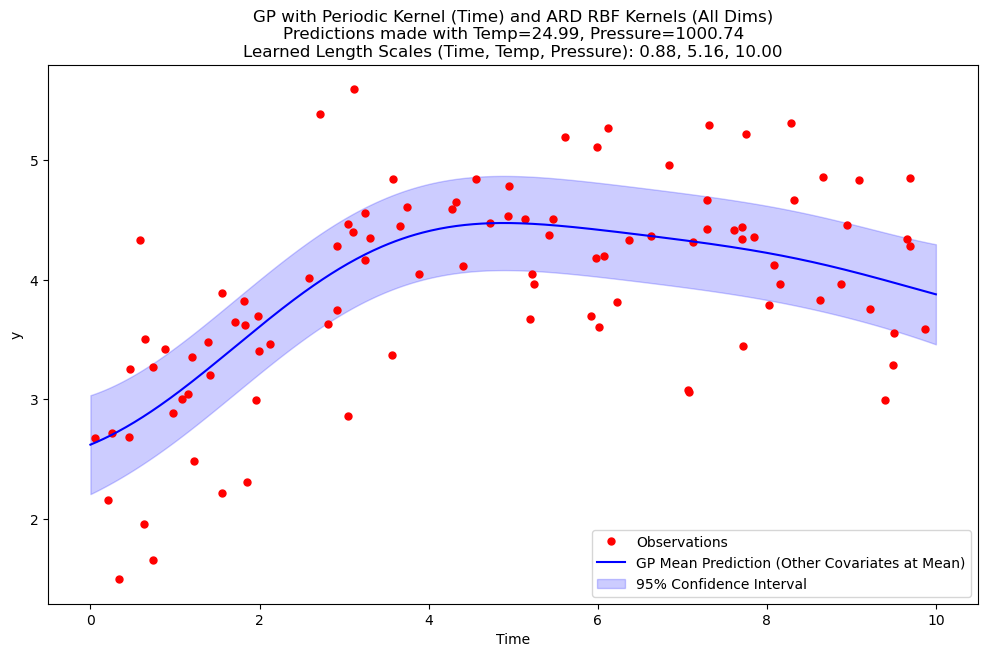


Log-marginal likelihood: -64.991


In [6]:

# --- 4. Make Predictions ---
# For prediction, you need to provide values for ALL covariates, and scale them.
time_pred = np.linspace(0, 10, 500).reshape(-1, 1)
mean_temp = np.mean(temp_data)
mean_pressure = np.mean(pressure_data)

X_pred_unscaled = np.hstack((time_pred,
                             np.full_like(time_pred, mean_temp),
                             np.full_like(time_pred, mean_pressure)))

X_pred_scaled = scaler_X.transform(X_pred_unscaled) # Scale prediction inputs with the same scaler

y_pred, sigma = gp.predict(X_pred_scaled, return_std=True)

# --- 5. Plot the Results ---
plt.figure(figsize=(12, 7))
plt.plot(X_full[:, 0], y, 'r.', markersize=10, label='Observations') # Plot y vs original time_data
plt.plot(X_pred_unscaled[:, 0], y_pred, 'b-', label='GP Mean Prediction (Other Covariates at Mean)')
plt.fill_between(X_pred_unscaled[:, 0].flatten(), y_pred - sigma, y_pred + sigma,
                 alpha=0.2, color='b', label='95% Confidence Interval')
plt.xlabel("Time")
plt.ylabel("y")
plt.title(f"GP with Periodic Kernel (Time) and ARD RBF Kernels (All Dims)\n"
          f"Predictions made with Temp={mean_temp:.2f}, Pressure={mean_pressure:.2f}\n"
          f"Learned Length Scales (Time, Temp, Pressure): {learned_ard_length_scales[0]:.2f}, {learned_ard_length_scales[1]:.2f}, {learned_ard_length_scales[2]:.2f}")
plt.legend()
plt.show()

print(f"\nLog-marginal likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta):.3f}")


Generating Partial Dependence Plots...
Displaying plots. Close the plot window to continue.


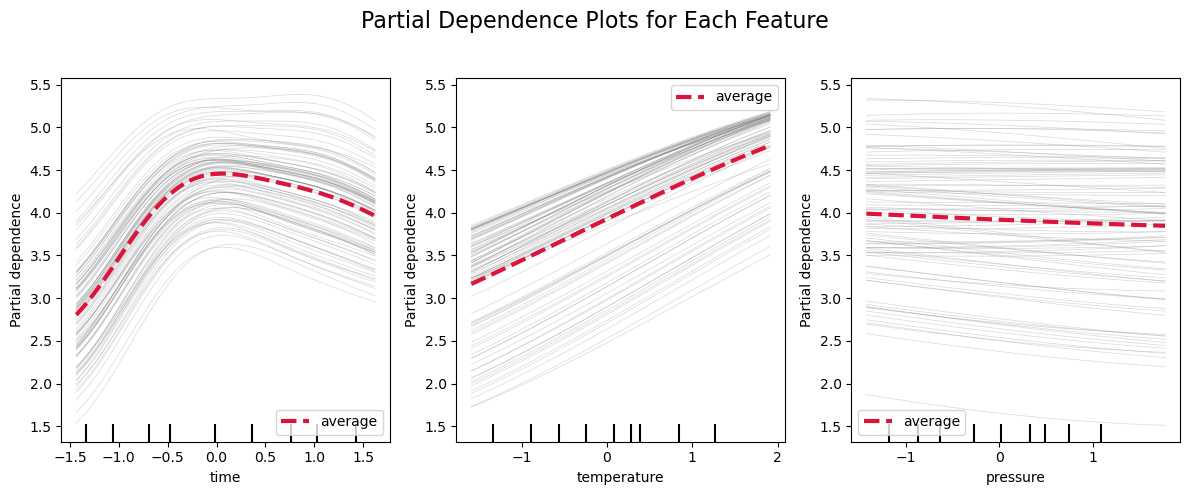


--- PDP Interpretation ---
1. Plot for 'X1 (Strong Effect)': Shows a clear sinusoidal curve, correctly capturing the strong, non-linear relationship.
2. Plot for 'X2 (Weak Effect)': Shows a gentle upward slope, correctly identifying the weak linear relationship.
3. Plot for 'X3 (No Effect)': Is almost completely flat, correctly showing that this feature has no impact on the model's predictions.


In [7]:
# 6. Generate and display Partial Dependence Plots
print("\nGenerating Partial Dependence Plots...")

# Create a figure and axes for the plots
fig, ax = plt.subplots(figsize=(12, 5), ncols=3)
fig.suptitle('Partial Dependence Plots for Each Feature', fontsize=16)

# The 'features' argument specifies which feature indices to plot.
# We will plot all three features.
# The 'line_kw' customizes the appearance of the PDP line.
# The 'ice_lines_kw' customizes the Individual Conditional Expectation lines (optional).
display = PartialDependenceDisplay.from_estimator(
    gp,
    X_full_scaled,
    features=[0, 1, 2],  # Indices of features to plot
    feature_names=feature_names, # Names for the plot axes
    ax=ax,
    line_kw={"color": "crimson", "linewidth": 3},
    ice_lines_kw={"color": "gray", "alpha": 0.3, "linewidth": 0.5},
    kind="both" # 'both' shows the PDP and individual ICE lines
)

fig.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle

# Show the plot
print("Displaying plots. Close the plot window to continue.")
plt.show()

print("\n--- PDP Interpretation ---")
print("1. Plot for 'X1 (Strong Effect)': Shows a clear sinusoidal curve, correctly capturing the strong, non-linear relationship.")
print("2. Plot for 'X2 (Weak Effect)': Shows a gentle upward slope, correctly identifying the weak linear relationship.")
print("3. Plot for 'X3 (No Effect)': Is almost completely flat, correctly showing that this feature has no impact on the model's predictions.")